In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mplt

from pathlib import Path

pd.set_option('display.max_rows', None)

We set some parameters to be used accross all notebook analysis.

In [81]:
SOURCE_LANGUAGES = ["en", "ru", "zh"]
FINETUNE_SIZES   = [6000000, 19000000, 60000000, 189000000, 600000000, 6000000000]

## Preparing the Data

In [82]:
raw_data = pd.read_csv("../results/experiments.csv")
raw_data.head()

,Unnamed: 0,loss,step,url,bucket,filename,initialization,target,model_size,data_size
0,0,2.364501,370,models/finetune/scratch_de_small_19M/,lang_agnostic,scratch_de_small_19M,scratch,de,small,19M
1,1,0.774575,15055,models/finetune/en_ar_small_189M/,lang_agnostic,en_ar_small_189M,en,ar,small,189M
2,2,0.865136,17170,models/finetune/en_zh_small_600M/,lang_agnostic,en_zh_small_600M,en,zh,small,600M
3,3,1.064009,3610,models/finetune/scratch_ja_small_189M/,lang_agnostic,scratch_ja_small_189M,scratch,ja,small,189M
4,4,0.674706,45780,models/finetune/en_zh_small_6B/,lang_agnostic,en_zh_small_6B,en,zh,small,6B


All size names are in the format `{number}{multiplier indicator}`. So, to be able to sort by those sizes, we convert them to their bytes.

In [83]:
MULTIPLIERS = {
    "M": 1000000,
    "B": 1000000000,
}

def convert_size_to_number(number_repr):
    suffix = number_repr[-1]
    multiplier = MULTIPLIERS[suffix]
    number_part = number_repr[:-1]
    
    return int(number_part) * multiplier


convert_size_to_number("65M")

65000000

We add some additional columns to help in the experiment analysis. Among them we have:

- *size*: a numeric representation of the data size
- *cross_lingual*: indicates whether or not the experiment uses a different language in initialization (from target)
- *perplexity*: we calculate the perplexitr from loss

In [84]:
raw_data["size"] = raw_data["data_size"].apply(convert_size_to_number)
raw_data["cross_lingual"] = raw_data["initialization"] != raw_data["target"]
raw_data["perplexity"] = np.exp(raw_data["loss"])

raw_data.head()

,Unnamed: 0,loss,step,url,bucket,filename,initialization,target,model_size,data_size,size,cross_lingual,perplexity
0,0,2.364501,370,models/finetune/scratch_de_small_19M/,lang_agnostic,scratch_de_small_19M,scratch,de,small,19M,19000000,True,10.638723
1,1,0.774575,15055,models/finetune/en_ar_small_189M/,lang_agnostic,en_ar_small_189M,en,ar,small,189M,189000000,True,2.169670
2,2,0.865136,17170,models/finetune/en_zh_small_600M/,lang_agnostic,en_zh_small_600M,en,zh,small,600M,600000000,True,2.375330
3,3,1.064009,3610,models/finetune/scratch_ja_small_189M/,lang_agnostic,scratch_ja_small_189M,scratch,ja,small,189M,189000000,True,2.897965
4,4,0.674706,45780,models/finetune/en_zh_small_6B/,lang_agnostic,en_zh_small_6B,en,zh,small,6B,6000000000,True,1.963456


In [85]:
cross_lingual_data = raw_data[raw_data.cross_lingual == True]

target_v_initialization = pd.pivot_table(cross_lingual_data, index=["target", "size"], columns="initialization", values="perplexity")
target_v_initialization[["scratch", "en", "ru", "zh", "pt"]]

initialization       scratch        en        ru        zh        pt
target size                                                         
ar     0           11.099188  4.471012  7.586950  4.539179       NaN
       6000000      6.443963  2.818745  2.830716  2.880094       NaN
       19000000     5.398603  2.573541  2.614603  2.678952       NaN
       60000000     3.111124  2.382326  2.438054  2.461752       NaN
       189000000    2.384848  2.169670  2.172620  2.208565       NaN
       600000000    2.105888  2.025625  2.031723  2.059278       NaN
       6000000000   1.929630  2.141356  1.930613  2.082330       NaN
de     0           24.134190  4.557543  5.585567  6.370033       NaN
       6000000     14.815842  3.666850  3.984010  4.264022       NaN
       19000000    10.295130  3.440617  3.626220  3.887831       NaN
       60000000     3.921004  3.107374  3.284250  3.342238       NaN
       189000000    3.206312  2.889578  2.970552  3.032195       NaN
       600000000    2.791715  2.680328  2.706459  2.747532       NaN
       6000000000   2.549487  2.654847  2.544245  2.707397       NaN
en     6000000     16.275217       NaN  3.662180  3.885537       NaN
       60000000     3.917610       NaN  3.226690  3.315622       NaN
       600000000    2.849276       NaN  2.776846  2.768537       NaN
       6000000000   2.682521       NaN  2.572163  2.665013       NaN
es     6000000     12.539025  3.163111  3.474664  3.752540  2.909573
       19000000     9.372363  2.943550  3.133820  3.519423  2.779108
       60000000     3.570520  2.741453  2.855067  2.987010  2.649243
       189000000    2.850784  2.581411  2.634654  2.692495  2.510469
       600000000    2.546002  2.408924  2.419389  2.455862  2.379263
       6000000000   2.557901  2.390901  2.271673  2.445876       NaN
fi     0           18.774242  5.724296  6.590427  6.933383       NaN
       6000000     12.714645  3.568337  3.800116  3.979684       NaN
       19000000     9.099923  3.237693  3.379644  3.556140       NaN
       60000000     3.725819  2.901409  3.006726  3.128807       NaN
       189000000    2.953213  2.662845  2.714177  2.795455       NaN
       600000000    2.592097  2.488557  2.489909  2.525235       NaN
       6000000000   2.413621  2.442999  2.459580  2.407570       NaN
id     0           22.865840  3.602278  4.706409  5.398109       NaN
       6000000     11.997169  2.609680  2.836732  2.977077       NaN
       19000000     7.772401  2.431387  2.579274  2.650573       NaN
       60000000     2.813704  2.276483  2.360225  2.410284       NaN
       189000000    2.322753  2.135157  2.188389  2.207095       NaN
       600000000    2.104967  2.025921  2.027535  2.050211       NaN
       6000000000   1.942082  2.001282       NaN  2.027612       NaN
ja     0           26.231975  6.079399  8.243286  4.716311       NaN
       6000000     12.468638  3.919586  3.891109  3.456637       NaN
       19000000     7.148220  3.322470  3.382605  3.155288       NaN
       60000000     3.551774  2.993006  3.023181  2.888835       NaN
       189000000    2.900728  2.706201  2.719937  2.649093       NaN
       600000000    2.540472  2.465089  2.454615  2.427642       NaN
       6000000000   2.277216  2.544193  2.308033  2.400873       NaN
ko     0           23.584094  6.394658  8.498488  5.190967       NaN
       6000000     11.686792  3.579865  3.584079  3.477913       NaN
       19000000     6.809712  3.112811  3.140066  3.124191       NaN
       60000000     3.334459  2.785987  2.822445  2.813633       NaN
       189000000    2.684107  2.526482  2.537097  2.543149       NaN
       600000000    2.386445  2.343350  2.336919  2.418162       NaN
       6000000000   2.220560  2.324495       NaN  2.914000       NaN
ru     0            9.733962  3.579393       NaN       NaN       NaN
       6000000      6.269366  2.443826       NaN  2.721920       NaN
       19000000     4.886091  2.211513       NaN  2.287652       NaN
       60000000     2.540096  2.058394       NaN  2.086784       Na

## Calculating the Data Transfer in bytes

First, we group the results by Source Language (the language used to pretrain the model). For every source language, we keep a Data Table which contains the scratch results alongside with results for that language. 

In [86]:
by_lang = {lang: target_v_initialization[["scratch", lang]] for lang in ["en", "zh", "ru"]}
by_lang["zh"]

initialization       scratch        zh
target size                           
ar     0           11.099188  4.539179
       6000000      6.443963  2.880094
       19000000     5.398603  2.678952
       60000000     3.111124  2.461752
       189000000    2.384848  2.208565
       600000000    2.105888  2.059278
       6000000000   1.929630  2.082330
de     0           24.134190  6.370033
       6000000     14.815842  4.264022
       19000000    10.295130  3.887831
       60000000     3.921004  3.342238
       189000000    3.206312  3.032195
       600000000    2.791715  2.747532
       6000000000   2.549487  2.707397
en     6000000     16.275217  3.885537
       60000000     3.917610  3.315622
       600000000    2.849276  2.768537
       6000000000   2.682521  2.665013
es     6000000     12.539025  3.752540
       19000000     9.372363  3.519423
       60000000     3.570520  2.987010
       189000000    2.850784  2.692495
       600000000    2.546002  2.455862
       6000000000   2.557901  2.445876
fi     0           18.774242  6.933383
       6000000     12.714645  3.979684
       19000000     9.099923  3.556140
       60000000     3.725819  3.128807
       189000000    2.953213  2.795455
       600000000    2.592097  2.525235
       6000000000   2.413621  2.407570
id     0           22.865840  5.398109
       6000000     11.997169  2.977077
       19000000     7.772401  2.650573
       60000000     2.813704  2.410284
       189000000    2.322753  2.207095
       600000000    2.104967  2.050211
       6000000000   1.942082  2.027612
ja     0           26.231975  4.716311
       6000000     12.468638  3.456637
       19000000     7.148220  3.155288
       60000000     3.551774  2.888835
       189000000    2.900728  2.649093
       600000000    2.540472  2.427642
       6000000000   2.277216  2.400873
ko     0           23.584094  5.190967
       6000000     11.686792  3.477913
       19000000     6.809712  3.124191
       60000000     3.334459  2.813633
       189000000    2.684107  2.543149
       600000000    2.386445  2.418162
       6000000000   2.220560  2.914000
ru     0            9.733962       NaN
       6000000      6.269366  2.721920
       19000000     4.886091  2.287652
       60000000     2.540096  2.086784
       189000000    2.049535  2.016428
       600000000    1.866623  1.828458
       6000000000   1.734547  1.877927
zh     0           29.921034       NaN
       6000000     15.340176       NaN
       19000000     8.133923       NaN
       60000000     3.728360       NaN
       189000000    2.774915       NaN
       600000000    2.277762       NaN
       6000000000   1.871711       NaN

Then, we estimate:

- D<sub>E</sub>: which is the Data effective amout, or the amout of finetune tokens that should be given to a model initialized from scratch so it can reach the same perplexity as the model which was pretrained and finetuned with a specific size.
- D<sub>T</sub>: which is the Data Transfer amount, or the D<sub>E</sub> subtract from the finetune dataset size. This indicator accounts for the estimated number of tokens (or data size) that a pretrained model is leveraging from its pretraining routine.
- D<sub>F</sub>: which is the size of the finetune dataset.


For estimating D<sub>E</sub>, we use linear interpolation from the set of data points that holds the performance of a model finetuned from scratch.

In [87]:
estimations = {"source": [], "target": [], "size": [], "perplexity": [], "scratch_perplexity": [], "dt": [], "de": [], "df": []}

for lang, lang_data in by_lang.items():
    languages = by_lang[lang].index.get_level_values(0).unique().to_list()
    languages.remove(lang)  # removing itself, since we are interested in cross lingual experiments

    for target in languages:
        target_data = lang_data.loc[target]
        target_data = target_data[target_data.index.isin(FINETUNE_SIZES)] # We do not consider, at first, zero-shot experiments

        x_values = target_data.index.to_numpy()

        y_values = target_data["scratch"].to_numpy()
        y_values_dotted = target_data[lang].to_numpy()

        estimated_de = np.interp(x=y_values_dotted, xp=y_values, fp=x_values, period=10)
        estimated_dt = estimated_de - x_values

        estimations["source"].extend([lang] * len(x_values))
        estimations["target"].extend([target] * len(x_values))
        estimations["size"].extend(x_values)
        estimations["perplexity"].extend(y_values_dotted)
        estimations["scratch_perplexity"].extend(y_values)
        estimations["de"].extend(estimated_de)
        estimations["df"].extend(x_values)
        estimations["dt"].extend(estimated_dt)


estimated_dt_table = pd.DataFrame.from_dict(estimations)
estimated_dt_table.head()

,source,target,size,perplexity,scratch_perplexity,dt,de,df
0,en,ar,6000000,2.818745,6.443963,1.059319e+08,1.119319e+08,6000000
1,en,ar,19000000,2.573541,5.398603,1.364847e+08,1.554847e+08,19000000
2,en,ar,60000000,2.382326,3.111124,1.327154e+08,1.927154e+08,60000000
3,en,ar,189000000,2.169670,2.384848,3.170269e+08,5.060269e+08,189000000
4,en,ar,600000000,2.025625,2.105888,2.459007e+09,3.059007e+09,600000000


In [88]:
estimated_dt_table[(estimated_dt_table["source"] == "en") & (estimated_dt_table["size"] == 6000000)]

,source,target,size,perplexity,scratch_perplexity,dt,de,df
0,en,ar,6000000,2.818745,6.443963,1.059319e+08,1.119319e+08,6000000
6,en,de,6000000,3.666850,14.815842,9.987413e+07,1.058741e+08,6000000
12,en,es,6000000,3.163111,12.539025,1.270209e+08,1.330209e+08,6000000
18,en,fi,6000000,3.568337,12.714645,8.029443e+07,8.629443e+07,6000000
24,en,id,6000000,2.609680,11.997169,1.076085e+08,1.136085e+08,6000000
30,en,ja,6000000,3.919586,12.468638,4.980689e+07,5.580689e+07,6000000
36,en,ko,6000000,3.579865,11.686792,5.110478e+07,5.710478e+07,6000000
42,en,ru,6000000,2.443826,6.269366,7.931563e+07,8.531563e+07,6000000
48,en,zh,6000000,4.425953,15.340176,3.062883e+07,3.662883e+07,6000000


In [89]:
estimated_dt_table[(estimated_dt_table.source == "en") & (estimated_dt_table.target == "es")]

,source,target,size,perplexity,scratch_perplexity,dt,de,df
12,en,es,6000000,3.163111,12.539025,1.270209e+08,1.330209e+08,6000000
13,en,es,19000000,2.943550,9.372363,1.533733e+08,1.723733e+08,19000000
14,en,es,60000000,2.741453,3.570520,2.298193e+09,2.358193e+09,60000000
15,en,es,189000000,2.581411,2.850784,5.344538e+09,5.533538e+09,189000000
16,en,es,600000000,2.408924,2.546002,-5.934659e+08,6.534101e+06,600000000
17,en,es,6000000000,2.390901,2.557901,-5.993392e+09,6.608090e+06,6000000000


Also, we calculate the fraction of D<sub>T</sub> by D<sub>E</sub>, which tells us how much of the performance of the model is estimated to be related to pretraining and not finetuning only:

In [90]:
estimated_dt_table["fraction_of_effective_dt"] = np.maximum(estimated_dt_table["dt"] / estimated_dt_table["de"], 0)
estimated_dt_table.head(5)

,source,target,size,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt
0,en,ar,6000000,2.818745,6.443963,1.059319e+08,1.119319e+08,6000000,0.946396
1,en,ar,19000000,2.573541,5.398603,1.364847e+08,1.554847e+08,19000000,0.877801
2,en,ar,60000000,2.382326,3.111124,1.327154e+08,1.927154e+08,60000000,0.688660
3,en,ar,189000000,2.169670,2.384848,3.170269e+08,5.060269e+08,189000000,0.626502
4,en,ar,600000000,2.025625,2.105888,2.459007e+09,3.059007e+09,600000000,0.803858


Finally, we add some formatted versions for the indicator columns, so it is easier to read:

In [91]:
def format_in_mega(v):
    return '{:,.2f} MB'.format(v / 1024 / 1024)


estimated_dt_table["dt_formatted"] = estimated_dt_table["dt"].map(format_in_mega)
estimated_dt_table["df_formatted"] = estimated_dt_table["df"].map(format_in_mega)
estimated_dt_table["de_formatted"] = estimated_dt_table["de"].map(format_in_mega)

estimated_dt_table.head(10)

,source,target,size,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt,dt_formatted,df_formatted,de_formatted
0,en,ar,6000000,2.818745,6.443963,1.059319e+08,1.119319e+08,6000000,0.946396,101.02 MB,5.72 MB,106.75 MB
1,en,ar,19000000,2.573541,5.398603,1.364847e+08,1.554847e+08,19000000,0.877801,130.16 MB,18.12 MB,148.28 MB
2,en,ar,60000000,2.382326,3.111124,1.327154e+08,1.927154e+08,60000000,0.688660,126.57 MB,57.22 MB,183.79 MB
3,en,ar,189000000,2.169670,2.384848,3.170269e+08,5.060269e+08,189000000,0.626502,302.34 MB,180.24 MB,482.58 MB
4,en,ar,600000000,2.025625,2.105888,2.459007e+09,3.059007e+09,600000000,0.803858,"2,345.09 MB",572.20 MB,"2,917.30 MB"
5,en,ar,6000000000,2.141356,1.929630,-5.452257e+09,5.477426e+08,6000000000,0.000000,"-5,199.68 MB","5,722.05 MB",522.37 MB
6,en,de,6000000,3.666850,14.815842,9.987413e+07,1.058741e+08,6000000,0.943329,95.25 MB,5.72 MB,100.97 MB
7,en,de,19000000,3.440617,10.295130,1.277086e+08,1.467086e+08,19000000,0.870492,121.79 MB,18.12 MB,139.91 MB
8,en,de,60000000,3.107374,3.921004,2.270794e+08,2.870794e+08,60000000,0.790999,216.56 MB,57.22 MB,273.78 MB
9,en,de,189000000,2.889578,3.206312,3.139865e+08,5.029865e+08,189000000,0.624244,299.44 MB,180.24 MB,479.69 MB


## Utility Chart Functions

For helping with the visualization of the results, we create some helper functions for ploting charts.

In [92]:
generate_latex_chart(estimated_dt_table, "fi")

en    source  perplexity        size
18     en    3.568337     6000000
19     en    3.237693    19000000
20     en    2.901409    60000000
21     en    2.662845   189000000
22     en    2.488557   600000000
23     en    2.442999  6000000000
ru     source  perplexity        size
128     ru    3.800116     6000000
129     ru    3.379644    19000000
130     ru    3.006726    60000000
131     ru    2.714177   189000000
132     ru    2.489909   600000000
133     ru    2.459580  6000000000
zh    source  perplexity        size
76     zh    3.979684     6000000
77     zh    3.556140    19000000
78     zh    3.128807    60000000
79     zh    2.795455   189000000
80     zh    2.525235   600000000
81     zh    2.407570  6000000000


In [93]:
def plot_by(data_table: pd.DataFrame,
            by: str,
            x: str,
            y: str,
            logx: bool = True,
            logy: bool = False,
            x_label: str = "Finetune dataset size",
            y_label: str="Dt",
            type: str = "-s",
            ymin_max = None
):
    """
    Plots, in the same chart, the values of (`x`, `y`) data points.
    Each unique value of `by` is plotted as a different series in the chart.
    """
    _, ax = mplt.subplots(figsize=(10,4))

    mplt.xlabel(x_label)
    mplt.ylabel(y_label)

    grouped = data_table.groupby(by)

    for group_name, indexes in grouped.groups.items():
        subset = data_table.iloc[indexes]

        y_values = np.log(subset[y]) if logy else subset[y]
        x_values = np.log(subset[x]) if logx else subset[x]

        mplt.plot(x_values, y_values, type, label=group_name)

    if ymin_max:
        ax.set_ylim(*ymin_max)

    mplt.legend()

In [94]:
def plot_chart_for_dt(target_language_data,
                      source_language,
                      target_language,
                      dt_table = None):
    """
    Plot a chart with both Perplexity curves: for a model trained from scratch and pretrained in `target_language`.
    The perplexities are drawn from finetuning the models in `target_language`.

    A line showing the estimated Dt for the first finetune size is shown if `dt_table` is provided.
    """    
    x_values = np.log(target_language_data.index[1:])
    y_values_scratch = target_language_data["scratch"][1:]
    y_values_source = target_language_data[source_language][1:]

    fig, ax = mplt.subplots(figsize=(5,3))

    mplt.xlabel("Finetune dataset size")
    mplt.ylabel("Perplexity")

    mplt.plot(x_values, y_values_scratch, '-ob')
    mplt.plot(x_values, y_values_source, '-ob', color='orange')

    if dt_table is not None:
        dts = np.log(dt_table[(dt_table["source"] == source_language) & (dt_table["target"] == target_language)]["dt"])
        x_coordinates = (x_values[0], dts.iloc[0])
        y_coordinates = (3, 3) # [y_values_source.iloc[0]] * 2
        
        mplt.plot(x_coordinates, y_coordinates, '-s', color="lightgrey")

    mplt.title(f"Data Transfer from {source_language} to {target_language}")

Let's also create some pre-defined filters to make it easy the analysis:

In [95]:
SIZE_6M = estimated_dt_table["size"]   == 6000000
SIZE_19M = estimated_dt_table["size"]  == 19000000
SIZE_60M = estimated_dt_table["size"]  == 60000000
SIZE_189M = estimated_dt_table["size"] == 189000000
SIZE_600M = estimated_dt_table["size"] == 600000000
SIZE_6B = estimated_dt_table["size"]   == 6000000000

## Checking the variance of data

First, we check how Data Transfer varies based on the target Language. This helps us to see if specific languages transfer better to a target language or not.

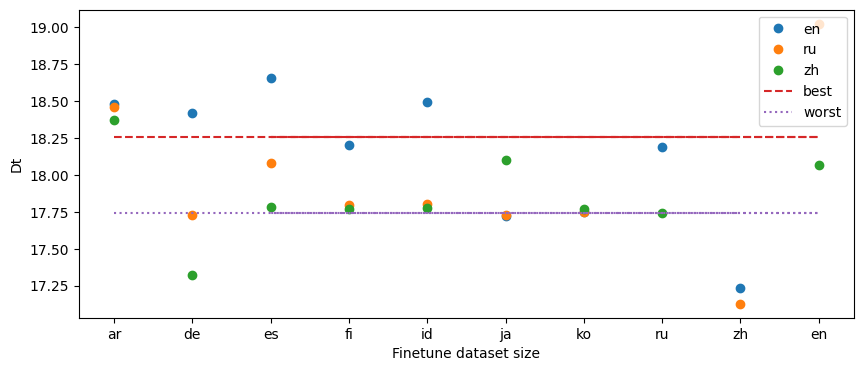

In [96]:
lang_table_6m = estimated_dt_table[SIZE_6M].reset_index()

plot_by(
    lang_table_6m,
    "source",
    "target",
    "dt",
    logx=False,
    logy=True,
    type="o")

on_max = lang_table_6m.groupby("target")[["dt", "source"]].idxmax(numeric_only=True)
on_min = lang_table_6m.groupby("target")[["dt", "source"]].idxmin(numeric_only=True)

best_on_every_language = lang_table_6m.iloc[on_max["dt"]][["source", "target", "dt"]]
worst_on_every_language = lang_table_6m.iloc[on_min["dt"]][["source", "target", "dt"]]

mplt.plot(best_on_every_language["target"], [np.log(best_on_every_language["dt"]).mean()] * len(best_on_every_language["target"]), "--", label="best")
mplt.plot(worst_on_every_language["target"], [np.log(worst_on_every_language["dt"]).mean()] * len(worst_on_every_language["target"]), ":", label="worst")

mplt.legend()

In [97]:
np.log(best_on_every_language["dt"]).mean()

18.25813794713682

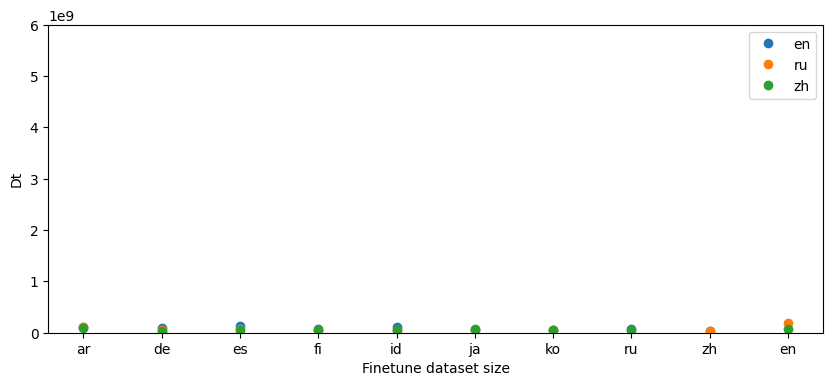

In [98]:
plot_by(
    lang_table_6m,
    "source",
    "target",
    "dt",
    logx=False,
    logy=False,
    type="o",
    ymin_max=(0, 6000000000))

In [99]:
SixM_results = estimated_dt_table[SIZE_6M].reset_index()
SixM_results["perplexity"] = SixM_results["perplexity"].map('{:,.2f}'.format)
SixM_results["scratch_perplexity"] = SixM_results["scratch_perplexity"].map('{:,.2f}'.format)



SixM_results

,index,source,target,size,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt,dt_formatted,df_formatted,de_formatted
0,0,en,ar,6000000,2.82,6.44,1.059319e+08,1.119319e+08,6000000,0.946396,101.02 MB,5.72 MB,106.75 MB
1,6,en,de,6000000,3.67,14.82,9.987413e+07,1.058741e+08,6000000,0.943329,95.25 MB,5.72 MB,100.97 MB
2,12,en,es,6000000,3.16,12.54,1.270209e+08,1.330209e+08,6000000,0.954894,121.14 MB,5.72 MB,126.86 MB
3,18,en,fi,6000000,3.57,12.71,8.029443e+07,8.629443e+07,6000000,0.930471,76.57 MB,5.72 MB,82.30 MB
4,24,en,id,6000000,2.61,12.00,1.076085e+08,1.136085e+08,6000000,0.947187,102.62 MB,5.72 MB,108.35 MB
5,30,en,ja,6000000,3.92,12.47,4.980689e+07,5.580689e+07,6000000,0.892486,47.50 MB,5.72 MB,53.22 MB
6,36,en,ko,6000000,3.58,11.69,5.110478e+07,5.710478e+07,6000000,0.894930,48.74 MB,5.72 MB,54.46 MB
7,42,en,ru,6000000,2.44,6.27,7.931563e+07,8.531563e+07,6000000,0.929673,75.64 MB,5.72 MB,81.36 MB
8,48,en,zh,6000000,4.43,15.34,3.062883e+07,3.662883e+07,6000000,0.836195,29.21 MB,5.72 MB,34.93 MB
9,54,zh,ar,6000000,2.88,6.44,9.503516e+07,1.010352e+08,6000000,0.940615,90.63 MB,5.72 MB,96.35 MB


Another hypothesis is that the models, regardless of pretraining, have very similar transfer abilities. So we plot a boxplot by Source Language to check if we have any indication of this

dt    Axes(0.125,0.11;0.775x0.77)
dtype: object

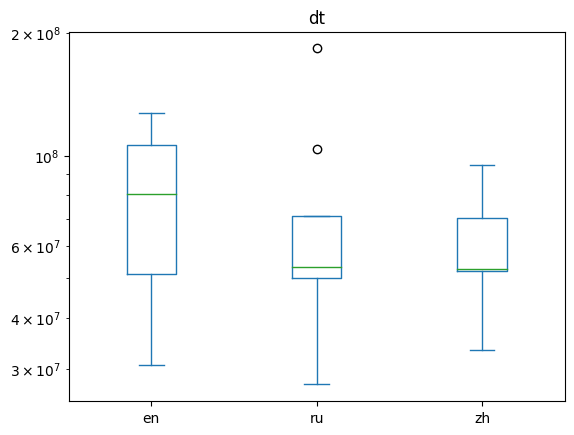

In [100]:
estimated_dt_table[(estimated_dt_table["size"] == 6000000)].plot.box(column="dt", by="source", logy=True)

In [101]:
estimated_dt_table["dt_in_mb"] = estimated_dt_table["dt"].apply(lambda v: v / 1024 / 1024)
estimated_dt_table[["dt", "dt_formatted", "dt_in_mb"]].head()

,dt,dt_formatted,dt_in_mb
0,1.059319e+08,101.02 MB,101.024562
1,1.364847e+08,130.16 MB,130.161968
2,1.327154e+08,126.57 MB,126.567283
3,3.170269e+08,302.34 MB,302.340393
4,2.459007e+09,"2,345.09 MB",2345.091893


In [102]:
estimated_dt_table[SIZE_60M & (estimated_dt_table["source"] == "en")]["dt_in_mb"]

2      126.567283
8      216.559786
14    2191.727211
20      85.127242
26     206.299739
32     105.586791
38     103.751799
44     120.802431
50      86.305672
Name: dt_in_mb, dtype: float64

In [103]:
estimated_dt_table.groupby(["source", "size"]).aggregate({"dt_in_mb": "mean"})

dt_in_mb
source size                   
en     6000000       77.521640
       19000000     107.992048
       60000000     360.303106
       189000000    770.304022
       600000000   1102.351874
       6000000000 -3540.894196
ru     6000000       68.259343
       19000000      87.582048
       60000000     132.304262
       189000000    631.756243
       600000000   1197.725152
       6000000000 -1350.355778
zh     6000000       56.367818
       19000000      80.794590
       60000000     127.096584
       189000000    503.806615
       600000000    886.010944
       6000000000 -3729.904897

## Analyzing D<sub>T</sub> across target languages

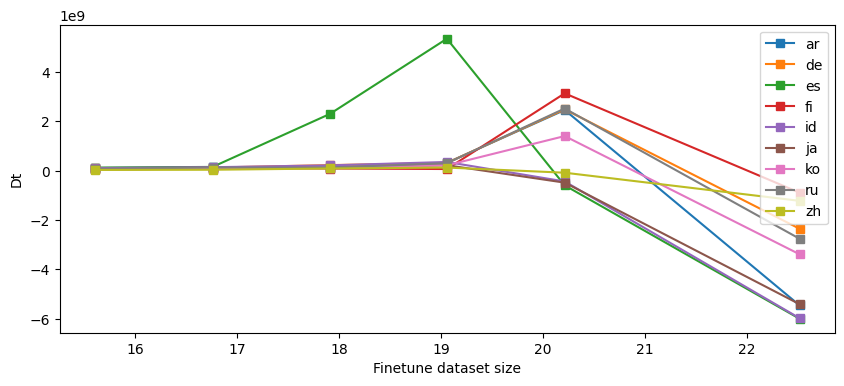

In [104]:
plot_by(estimated_dt_table[estimated_dt_table["source"] == "en"].reset_index(), "target", "size", "dt")

/Users/leandro.desouza/Source/lersouza/language-transfer/.lang_transfer/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


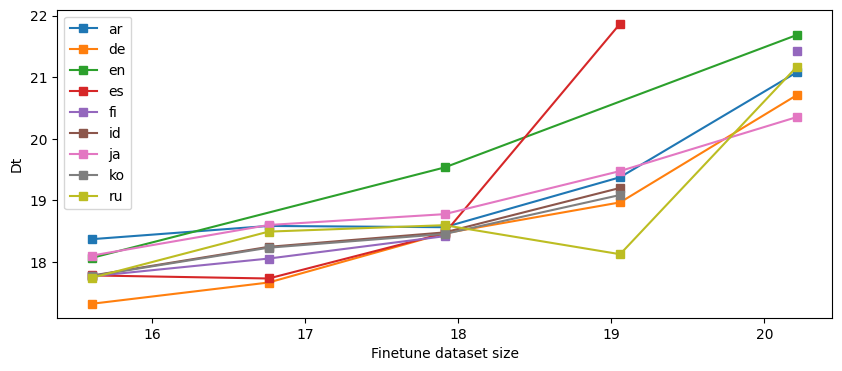

In [105]:
plot_by(estimated_dt_table[estimated_dt_table["source"] == "zh"].reset_index(), "target", "size", "dt", logy=True)

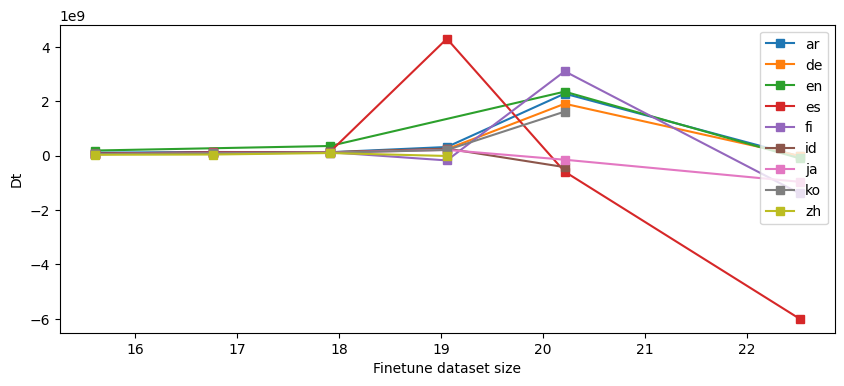

In [106]:
plot_by(estimated_dt_table[estimated_dt_table["source"] == "ru"].reset_index(), "target", "size", "dt")

In [107]:
estimated_dt_table[(estimated_dt_table["size"] == 6000000) & (estimated_dt_table["target"] == "de")]

,source,target,size,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt,dt_formatted,df_formatted,de_formatted,dt_in_mb
6,en,de,6000000,3.666850,14.815842,9.987413e+07,1.058741e+08,6000000,0.943329,95.25 MB,5.72 MB,100.97 MB,95.247396
60,zh,de,6000000,4.264022,14.815842,3.330020e+07,3.930020e+07,6000000,0.847329,31.76 MB,5.72 MB,37.48 MB,31.757547
112,ru,de,6000000,3.984010,14.815842,5.019782e+07,5.619782e+07,6000000,0.893234,47.87 MB,5.72 MB,53.59 MB,47.872374


In [108]:
estimated_dt_table[(estimated_dt_table["size"] == 6000000) & (estimated_dt_table["target"] == "id")]

,source,target,size,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt,dt_formatted,df_formatted,de_formatted,dt_in_mb
24,en,id,6000000,2.609680,11.997169,1.076085e+08,1.136085e+08,6000000,0.947187,102.62 MB,5.72 MB,108.35 MB,102.623454
82,zh,id,6000000,2.977077,11.997169,5.264918e+07,5.864918e+07,6000000,0.897697,50.21 MB,5.72 MB,55.93 MB,50.210175
134,ru,id,6000000,2.836732,11.997169,5.380960e+07,5.980960e+07,6000000,0.899682,51.32 MB,5.72 MB,57.04 MB,51.316833


In [109]:
estimated_dt_table[(estimated_dt_table["size"] == 6000000) & (estimated_dt_table["target"] == "ja")]

,source,target,size,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt,dt_formatted,df_formatted,de_formatted,dt_in_mb
30,en,ja,6000000,3.919586,12.468638,4.980689e+07,5.580689e+07,6000000,0.892486,47.50 MB,5.72 MB,53.22 MB,47.499556
88,zh,ja,6000000,3.456637,12.468638,7.285078e+07,7.885078e+07,6000000,0.923907,69.48 MB,5.72 MB,75.20 MB,69.475917
140,ru,ja,6000000,3.891109,12.468638,5.013154e+07,5.613154e+07,6000000,0.893108,47.81 MB,5.72 MB,53.53 MB,47.809158


In [110]:
estimated_dt_table[(estimated_dt_table["size"] == 6000000) & (estimated_dt_table["target"] == "ko")]

,source,target,size,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt,dt_formatted,df_formatted,de_formatted,dt_in_mb
36,en,ko,6000000,3.579865,11.686792,5.110478e+07,5.710478e+07,6000000,0.894930,48.74 MB,5.72 MB,54.46 MB,48.737314
94,zh,ko,6000000,3.477913,11.686792,5.230758e+07,5.830758e+07,6000000,0.897097,49.88 MB,5.72 MB,55.61 MB,49.884398
146,ru,ko,6000000,3.584079,11.686792,5.105506e+07,5.705506e+07,6000000,0.894838,48.69 MB,5.72 MB,54.41 MB,48.689904


In [111]:
estimated_dt_table[(estimated_dt_table["size"] == 6000000) & (estimated_dt_table["target"] == "ar")]

,source,target,size,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt,dt_formatted,df_formatted,de_formatted,dt_in_mb
0,en,ar,6000000,2.818745,6.443963,1.059319e+08,1.119319e+08,6000000,0.946396,101.02 MB,5.72 MB,106.75 MB,101.024562
54,zh,ar,6000000,2.880094,6.443963,9.503516e+07,1.010352e+08,6000000,0.940615,90.63 MB,5.72 MB,96.35 MB,90.632594
106,ru,ar,6000000,2.830716,6.443963,1.038057e+08,1.098057e+08,6000000,0.945358,99.00 MB,5.72 MB,104.72 MB,98.996809


## Commutative

In [112]:
estimated_dt_table[SIZE_6M & (estimated_dt_table["target"].isin(["en", "zh", "ru"]))]

,source,target,size,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt,dt_formatted,df_formatted,de_formatted,dt_in_mb
42,en,ru,6000000,2.443826,6.269366,7.931563e+07,8.531563e+07,6000000,0.929673,75.64 MB,5.72 MB,81.36 MB,75.641277
48,en,zh,6000000,4.425953,15.340176,3.062883e+07,3.662883e+07,6000000,0.836195,29.21 MB,5.72 MB,34.93 MB,29.209931
66,zh,en,6000000,3.885537,16.275217,7.021128e+07,7.621128e+07,6000000,0.921271,66.96 MB,5.72 MB,72.68 MB,66.958695
100,zh,ru,6000000,2.721920,6.269366,5.082234e+07,5.682234e+07,6000000,0.894408,48.47 MB,5.72 MB,54.19 MB,48.467961
118,ru,en,6000000,3.662180,16.275217,1.831094e+08,1.891094e+08,6000000,0.968272,174.63 MB,5.72 MB,180.35 MB,174.626716
152,ru,zh,6000000,4.520740,15.340176,2.745323e+07,3.345323e+07,6000000,0.820645,26.18 MB,5.72 MB,31.90 MB,26.181445


## Exploring possible explanations

For exploring explanations, we calculate the Spearman correlation across some variables. We also calculate the *p-value* for assessing for statistic significance. Both correlation and *p-value* are calculated using `scipy`.
Since our sample is small (< 500 samples), we perform a permutation-test instead of relying on the calulated *p-value* for the Spearman correlation.

The following functions help to do that:

In [113]:
from scipy import stats
from functools import partial


def statistic(x, y):
    n = len(x)
    dof = n - 2

    rs = stats.spearmanr(x, y).statistic
    transformed = rs * np.sqrt(dof / ((rs+1.0)*(1.0-rs)))

    return transformed


def calculate_correlation(x, y):
    rs = stats.spearmanr(x, y)
    ptr = stats.permutation_test((x,), partial(statistic, y), alternative="greater", permutation_type="pairings")

    rho = rs.statistic
    pvalue = ptr.pvalue

    return rho, pvalue

### Preparing the data

In [114]:
data = {}

#### Contamination on Source

We read data for data contamination in the pretraining dataset

In [115]:
language_contamination_data = pd.concat([pd.read_csv(f"../results/languages_in_{l}_6B_byline_dataset.csv") for l in SOURCE_LANGUAGES])
language_contamination_data.head()

,source_language,size,target_language,sentences
0,en,6B,__label__other,6021811
1,en,6B,__label__en,21933341
2,en,6B,__label__de,49862
3,en,6B,__label__fr,44873
4,en,6B,__label__vi,4810


Calculate the ratio of each language for the dataset, normalize the language name (for joining with the D<sub>T</sub> estimations), and convert size name to bytes:

In [116]:
all_sequences = language_contamination_data.groupby("source_language")["sentences"].sum()

language_contamination_data["lang_ratio"] = language_contamination_data.apply(lambda r: r["sentences"] / all_sequences[r["source_language"]], axis=1)
language_contamination_data["target_language_name"] = language_contamination_data["target_language"].apply(lambda e: e.split("_")[-1])
language_contamination_data["size_in_bytes"] = language_contamination_data["size"].apply(convert_size_to_number)

language_contamination_data.head()

,source_language,size,target_language,sentences,lang_ratio,target_language_name,size_in_bytes
0,en,6B,__label__other,6021811,0.213416,other,6000000000
1,en,6B,__label__en,21933341,0.777327,en,6000000000
2,en,6B,__label__de,49862,0.001767,de,6000000000
3,en,6B,__label__fr,44873,0.001590,fr,6000000000
4,en,6B,__label__vi,4810,0.000170,vi,6000000000


In [117]:
language_contamination_data.describe()

,sentences,lang_ratio,size_in_bytes
count,3.280000e+02,3.280000e+02,3.280000e+02
mean,1.903902e+05,9.146341e-03,6.000000e+09
std,1.697703e+06,8.032278e-02,0.000000e+00
min,1.000000e+00,3.544044e-08,6.000000e+09
25%,4.000000e+00,1.773481e-07,6.000000e+09
50%,4.750000e+01,2.286857e-06,6.000000e+09
75%,3.747500e+02,1.892429e-05,6.000000e+09
max,2.193334e+07,9.102415e-01,6.000000e+09


And, then, join and caculate the corralation

In [118]:
data["contamination_on_source"] = estimated_dt_table.merge(
    language_contamination_data,
    "inner",
    left_on=["source", "target"],
    right_on=["source_language", "target_language_name"])

data["contamination_on_source"].head(50)

,source,target,size_x,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt,dt_formatted,df_formatted,de_formatted,dt_in_mb,source_language,size_y,target_language,sentences,lang_ratio,target_language_name,size_in_bytes
0,en,ar,6000000,2.818745,6.443963,1.059319e+08,1.119319e+08,6000000,0.946396,101.02 MB,5.72 MB,106.75 MB,101.024562,en,6B,__label__ar,2515,0.000089,ar,6000000000
1,en,ar,19000000,2.573541,5.398603,1.364847e+08,1.554847e+08,19000000,0.877801,130.16 MB,18.12 MB,148.28 MB,130.161968,en,6B,__label__ar,2515,0.000089,ar,6000000000
2,en,ar,60000000,2.382326,3.111124,1.327154e+08,1.927154e+08,60000000,0.688660,126.57 MB,57.22 MB,183.79 MB,126.567283,en,6B,__label__ar,2515,0.000089,ar,6000000000
3,en,ar,189000000,2.169670,2.384848,3.170269e+08,5.060269e+08,189000000,0.626502,302.34 MB,180.24 MB,482.58 MB,302.340393,en,6B,__label__ar,2515,0.000089,ar,6000000000
4,en,ar,600000000,2.025625,2.105888,2.459007e+09,3.059007e+09,600000000,0.803858,"2,345.09 MB",572.20 MB,"2,917.30 MB",2345.091893,en,6B,__label__ar,2515,0.000089,ar,6000000000
5,en,ar,6000000000,2.141356,1.929630,-5.452257e+09,5.477426e+08,6000000000,0.000000,"-5,199.68 MB","5,722.05 MB",522.37 MB,-5199.677829,en,6B,__label__ar,2515,0.000089,ar,6000000000
6,en,de,6000000,3.666850,14.815842,9.987413e+07,1.058741e+08,6000000,0.943329,95.25 MB,5.72 MB,100.97 MB,95.247396,en,6B,__label__de,49862,0.001767,de,6000000000
7,en,de,19000000,3.440617,10.295130,1.277086e+08,1.467086e+08,19000000,0.870492,121.79 MB,18.12 MB,139.91 MB,121.792432,en,6B,__label__de,49862,0.001767,de,6000000000
8,en,de,60000000,3.107374,3.921004,2.270794e+08,2.870794e+08,60000000,0.790999,216.56 MB,57.22 MB,273.78 MB,216.559786,en,6B,__label__de,49862,0.001767,de,6000000000
9,en,de,189000000,2.889578,3.206312,3.139865e+08,5.029865e+08,189000000,0.624244,299.44 MB,180.24 MB,479.69 MB,299.440845,en,6B,__label__de,49862,0.001767,de,6000000000


#### Contamination on Target

In [119]:
language_contamination_on_target = pd.concat(map(pd.read_csv, [str(p) for p in Path("../results/").glob("languages_in_*_*_byline_dataset.csv")]))
language_contamination_on_target.head()

,source_language,size,target_language,sentences
0,ar,6M,__label__ar,21853
1,ar,6M,__label__other,1618
2,ar,6M,__label__en,331
3,ar,6M,__label__arz,163
4,ar,6M,__label__fr,41


In [120]:
all_sequences_on_target = language_contamination_on_target.groupby("source_language")["sentences"].sum()

language_contamination_on_target["lang_ratio"] = language_contamination_on_target.apply(lambda r: r["sentences"] / all_sequences_on_target[r["source_language"]], axis=1)
language_contamination_on_target["target_language_name"] = language_contamination_on_target["target_language"].apply(lambda e: e.split("_")[-1])
language_contamination_on_target["size_in_bytes"] = language_contamination_on_target["size"].apply(convert_size_to_number)

language_contamination_on_target.head()

,source_language,size,target_language,sentences,lang_ratio,target_language_name,size_in_bytes
0,ar,6M,__label__ar,21853,0.001034,ar,6000000
1,ar,6M,__label__other,1618,0.000077,other,6000000
2,ar,6M,__label__en,331,0.000016,en,6000000
3,ar,6M,__label__arz,163,0.000008,arz,6000000
4,ar,6M,__label__fr,41,0.000002,fr,6000000


In [121]:
language_contamination_on_target.describe()

,lang_ratio,size_in_bytes
count,3.461000e+03,3.461000e+03
mean,3.178272e-03,2.310964e+09
std,4.125714e-02,2.760533e+09
min,2.814903e-08,6.000000e+06
25%,8.551924e-08,6.000000e+07
50%,4.923830e-07,6.000000e+08
75%,4.531994e-06,6.000000e+09
max,8.749371e-01,6.000000e+09


In [122]:
data["contamination_on_target"] = estimated_dt_table.merge(
    language_contamination_on_target,
    "inner",
    left_on=["target", "source", "size"],
    right_on=["source_language", "target_language_name", "size_in_bytes"])

data["contamination_on_target"].head(20)

,source,target,size_x,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt,dt_formatted,df_formatted,de_formatted,dt_in_mb,source_language,size_y,target_language,sentences,lang_ratio,target_language_name,size_in_bytes
0,en,ar,6000000,2.818745,6.443963,1.059319e+08,1.119319e+08,6000000,0.946396,101.02 MB,5.72 MB,106.75 MB,101.024562,ar,6M,__label__en,331,0.000016,en,6000000
1,en,ar,19000000,2.573541,5.398603,1.364847e+08,1.554847e+08,19000000,0.877801,130.16 MB,18.12 MB,148.28 MB,130.161968,ar,19M,__label__en,775,0.000037,en,19000000
2,en,ar,60000000,2.382326,3.111124,1.327154e+08,1.927154e+08,60000000,0.688660,126.57 MB,57.22 MB,183.79 MB,126.567283,ar,60M,__label__en,2390,0.000113,en,60000000
3,en,ar,189000000,2.169670,2.384848,3.170269e+08,5.060269e+08,189000000,0.626502,302.34 MB,180.24 MB,482.58 MB,302.340393,ar,189M,__label__en,6258,0.000296,en,189000000
4,en,ar,6000000000,2.141356,1.929630,-5.452257e+09,5.477426e+08,6000000000,0.000000,"-5,199.68 MB","5,722.05 MB",522.37 MB,-5199.677829,ar,6B,__label__en,210287,0.009950,en,6000000000
5,en,de,6000000,3.666850,14.815842,9.987413e+07,1.058741e+08,6000000,0.943329,95.25 MB,5.72 MB,100.97 MB,95.247396,de,6M,__label__en,684,0.000019,en,6000000
6,en,de,19000000,3.440617,10.295130,1.277086e+08,1.467086e+08,19000000,0.870492,121.79 MB,18.12 MB,139.91 MB,121.792432,de,19M,__label__en,2057,0.000058,en,19000000
7,en,de,60000000,3.107374,3.921004,2.270794e+08,2.870794e+08,60000000,0.790999,216.56 MB,57.22 MB,273.78 MB,216.559786,de,60M,__label__en,7416,0.000209,en,60000000
8,en,de,189000000,2.889578,3.206312,3.139865e+08,5.029865e+08,189000000,0.624244,299.44 MB,180.24 MB,479.69 MB,299.440845,de,189M,__label__en,23680,0.000668,en,189000000
9,en,de,600000000,2.680328,2.791715,2.483159e+09,3.083159e+09,600000000,0.805394,"2,368.13 MB",572.20 MB,"2,940.33 MB",2368.125402,de,600M,__label__en,71497,0.002015,en,600000000


#### Language distance

In [123]:
import lang2vec.lang2vec as l2v

We add a dictionary to convert from ISO 639-1 language code convention (which we use throughout our experiments) to ISO 639-3, which the `lang2vec` library uses.

In [124]:
# Imported from http://www-01.sil.org/iso639-3/download.asp on July 12, 2014
ISO_639_1_TO_3 = {
    'aa': 'aar',
    'ab': 'abk',
    'ae': 'ave',
    'af': 'afr',
    'ak': 'aka',
    'am': 'amh',
    'an': 'arg',
    'ar': 'ara',
    'as': 'asm',
    'av': 'ava',
    'ay': 'aym',
    'az': 'aze',
    'ba': 'bak',
    'be': 'bel',
    'bg': 'bul',
    'bi': 'bis',
    'bm': 'bam',
    'bn': 'ben',
    'bo': 'bod',
    'br': 'bre',
    'bs': 'bos',
    'ca': 'cat',
    'ce': 'che',
    'ch': 'cha',
    'co': 'cos',
    'cr': 'cre',
    'cs': 'ces',
    'cu': 'chu',
    'cv': 'chv',
    'cy': 'cym',
    'da': 'dan',
    'de': 'deu',
    'dv': 'div',
    'dz': 'dzo',
    'ee': 'ewe',
    'el': 'ell',
    'en': 'eng',
    'eo': 'epo',
    'es': 'spa',
    'et': 'est',
    'eu': 'eus',
    'fa': 'fas',
    'ff': 'ful',
    'fi': 'fin',
    'fj': 'fij',
    'fo': 'fao',
    'fr': 'fra',
    'fy': 'fry',
    'ga': 'gle',
    'gd': 'gla',
    'gl': 'glg',
    'gn': 'grn',
    'gu': 'guj',
    'gv': 'glv',
    'ha': 'hau',
    'he': 'heb',
    'hi': 'hin',
    'ho': 'hmo',
    'hr': 'hrv',
    'ht': 'hat',
    'hu': 'hun',
    'hy': 'hye',
    'hz': 'her',
    'ia': 'ina',
    'id': 'ind',
    'ie': 'ile',
    'ig': 'ibo',
    'ii': 'iii',
    'ik': 'ipk',
    'io': 'ido',
    'is': 'isl',
    'it': 'ita',
    'iu': 'iku',
    'ja': 'jpn',
    'jv': 'jav',
    'ka': 'kat',
    'kg': 'kon',
    'ki': 'kik',
    'kj': 'kua',
    'kk': 'kaz',
    'kl': 'kal',
    'km': 'khm',
    'kn': 'kan',
    'ko': 'kor',
    'kr': 'kau',
    'ks': 'kas',
    'ku': 'kur',
    'kv': 'kom',
    'kw': 'cor',
    'ky': 'kir',
    'la': 'lat',
    'lb': 'ltz',
    'lg': 'lug',
    'li': 'lim',
    'ln': 'lin',
    'lo': 'lao',
    'lt': 'lit',
    'lu': 'lub',
    'lv': 'lav',
    'mg': 'mlg',
    'mh': 'mah',
    'mi': 'mri',
    'mk': 'mkd',
    'ml': 'mal',
    'mn': 'mon',
    'mr': 'mar',
    'ms': 'msa',
    'mt': 'mlt',
    'my': 'mya',
    'na': 'nau',
    'nb': 'nob',
    'nd': 'nde',
    'ne': 'nep',
    'ng': 'ndo',
    'nl': 'nld',
    'nn': 'nno',
    'no': 'nor',
    'nr': 'nbl',
    'nv': 'nav',
    'ny': 'nya',
    'oc': 'oci',
    'oj': 'oji',
    'om': 'orm',
    'or': 'ori',
    'os': 'oss',
    'pa': 'pan',
    'pi': 'pli',
    'pl': 'pol',
    'ps': 'pus',
    'pt': 'por',
    'qu': 'que',
    'rm': 'roh',
    'rn': 'run',
    'ro': 'ron',
    'ru': 'rus',
    'rw': 'kin',
    'sa': 'san',
    'sc': 'srd',
    'sd': 'snd',
    'se': 'sme',
    'sg': 'sag',
    'sh': 'hbs',
    'si': 'sin',
    'sk': 'slk',
    'sl': 'slv',
    'sm': 'smo',
    'sn': 'sna',
    'so': 'som',
    'sq': 'sqi',
    'sr': 'srp',
    'ss': 'ssw',
    'st': 'sot',
    'su': 'sun',
    'sv': 'swe',
    'sw': 'swa',
    'ta': 'tam',
    'te': 'tel',
    'tg': 'tgk',
    'th': 'tha',
    'ti': 'tir',
    'tk': 'tuk',
    'tl': 'tgl',
    'tn': 'tsn',
    'to': 'ton',
    'tr': 'tur',
    'ts': 'tso',
    'tt': 'tat',
    'tw': 'twi',
    'ty': 'tah',
    'ug': 'uig',
    'uk': 'ukr',
    'ur': 'urd',
    'uz': 'uzb',
    've': 'ven',
    'vi': 'vie',
    'vo': 'vol',
    'wa': 'wln',
    'wo': 'wol',
    'xh': 'xho',
    'yi': 'yid',
    'yo': 'yor',
    'za': 'zha',
    'zh': 'zho',
    'zu': 'zul'}

We then create a function for calculating the distance between source language and target language for any given row.

In [125]:
def calculate_distance(row):
    lang_a = ISO_639_1_TO_3.get(row["source"])
    lang_b = ISO_639_1_TO_3.get(row["target"])

    distance = l2v.distance("syntactic", lang_a, lang_b)

    return distance

In [134]:
estimated_dt_table["lang_distance"] = data["language_distance"].apply(calculate_distance, axis=1, )

data["language_distance"] = estimated_dt_table.dropna()
data["language_distance"].head(20)

,source,target,size,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt,dt_formatted,df_formatted,de_formatted,dt_in_mb,lang_distance
0,en,ar,6000000,2.818745,6.443963,1.059319e+08,1.119319e+08,6000000,0.946396,101.02 MB,5.72 MB,106.75 MB,101.024562,0.57
1,en,ar,19000000,2.573541,5.398603,1.364847e+08,1.554847e+08,19000000,0.877801,130.16 MB,18.12 MB,148.28 MB,130.161968,0.57
2,en,ar,60000000,2.382326,3.111124,1.327154e+08,1.927154e+08,60000000,0.688660,126.57 MB,57.22 MB,183.79 MB,126.567283,0.57
3,en,ar,189000000,2.169670,2.384848,3.170269e+08,5.060269e+08,189000000,0.626502,302.34 MB,180.24 MB,482.58 MB,302.340393,0.57
4,en,ar,600000000,2.025625,2.105888,2.459007e+09,3.059007e+09,600000000,0.803858,"2,345.09 MB",572.20 MB,"2,917.30 MB",2345.091893,0.57
6,en,de,6000000,3.666850,14.815842,9.987413e+07,1.058741e+08,6000000,0.943329,95.25 MB,5.72 MB,100.97 MB,95.247396,0.42
7,en,de,19000000,3.440617,10.295130,1.277086e+08,1.467086e+08,19000000,0.870492,121.79 MB,18.12 MB,139.91 MB,121.792432,0.42
8,en,de,60000000,3.107374,3.921004,2.270794e+08,2.870794e+08,60000000,0.790999,216.56 MB,57.22 MB,273.78 MB,216.559786,0.42
9,en,de,189000000,2.889578,3.206312,3.139865e+08,5.029865e+08,189000000,0.624244,299.44 MB,180.24 MB,479.69 MB,299.440845,0.42
10,en,de,600000000,2.680328,2.791715,2.483159e+09,3.083159e+09,600000000,0.805394,"2,368.13 MB",572.20 MB,"2,940.33 MB",2368.125402,0.42


### Calculating the relationships

Calculating the Spearman Correlation Coefficient (monotonic relation) $r$<sub>s</sub> between D<sub>T</sub> and the ration of target language in the source corpora.

First of all, since we observe the ossification effect, perplexity on the 6B dataset for a pretrained model is worse than a scratch-initialized model. So, de estimations for $D_E$ gets very noisy, once this ossification effect occur on a 6B token dataset (which is the last data point we have) and the drop is, for instance, from a $D_T$ of 2GB to a $D_T$ of -6GB. This noisy negatively affect the correlation coeficients, making its p-value outside the cut-off.

So, we remove those data points and calculate the the coefficients then.

In [143]:
rm = [(k, type(data[k])) for k in data.keys()]
rm

[('contamination_on_source', pandas.core.frame.DataFrame),
 ('contamination_on_target', pandas.core.frame.DataFrame),
 ('language_distance', pandas.core.frame.DataFrame)]

In [146]:
data_original = {}

for k, v in data.items():
    
    # Preserve the original datasets before changing them
    data_original[k] = v

    size_col = "size_x" if "size_x" in data[k].columns else "size"
    data[k] = data[k][data[k][size_col] != 6000000000].dropna()


We start it by Language contamination on Source.

In [147]:
X = data["contamination_on_source"]["lang_ratio"]
Y = data["contamination_on_source"]["dt"]

n = len(X)

rho_contamination, pvalue_contamination = calculate_correlation(Y, X)
n, rho_contamination, pvalue_contamination

(130, 0.19132763465633823, 0.0157)

In [148]:
X = data["contamination_on_target"]["lang_ratio"]
Y = data["contamination_on_target"]["dt"]

n = len(X)

rho_contamination, pvalue_contamination = calculate_correlation(Y, X)
n, rho_contamination, pvalue_contamination

(122, 0.2645520304274984, 0.0021)

In [149]:
X = data["language_distance"]["lang_distance"]
Y = data["language_distance"]["dt"]

n = len(X)

rho_contamination, pvalue_contamination = calculate_correlation(Y, X)
n, rho_contamination, pvalue_contamination

(130, -0.22051286042636828, 0.9942)

## LaTeX Help

In [150]:
def generate_latex_chart(data_table, target_language):
    results = data_table[data_table["target"] == target_language][["source", "perplexity", "size"]]
    by_source = results.groupby("source")

    
    for source_lang, indexes in by_source.groups.items():
        data = results.loc[indexes]

        print(source_lang, data)


generate_latex_chart(estimated_dt_table, "fi")
    

en    source  perplexity        size
18     en    3.568337     6000000
19     en    3.237693    19000000
20     en    2.901409    60000000
21     en    2.662845   189000000
22     en    2.488557   600000000
23     en    2.442999  6000000000
ru     source  perplexity        size
128     ru    3.800116     6000000
129     ru    3.379644    19000000
130     ru    3.006726    60000000
131     ru    2.714177   189000000
132     ru    2.489909   600000000
133     ru    2.459580  6000000000
zh    source  perplexity        size
76     zh    3.979684     6000000
77     zh    3.556140    19000000
78     zh    3.128807    60000000
79     zh    2.795455   189000000
80     zh    2.525235   600000000
81     zh    2.407570  6000000000
